# **BUSINESS UNDERSTANDING**


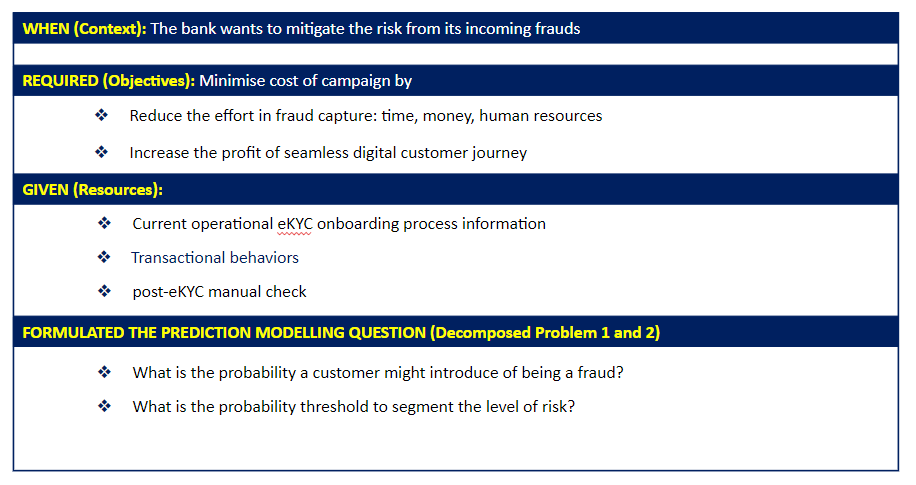

# **DATA UNDERSTANDING**

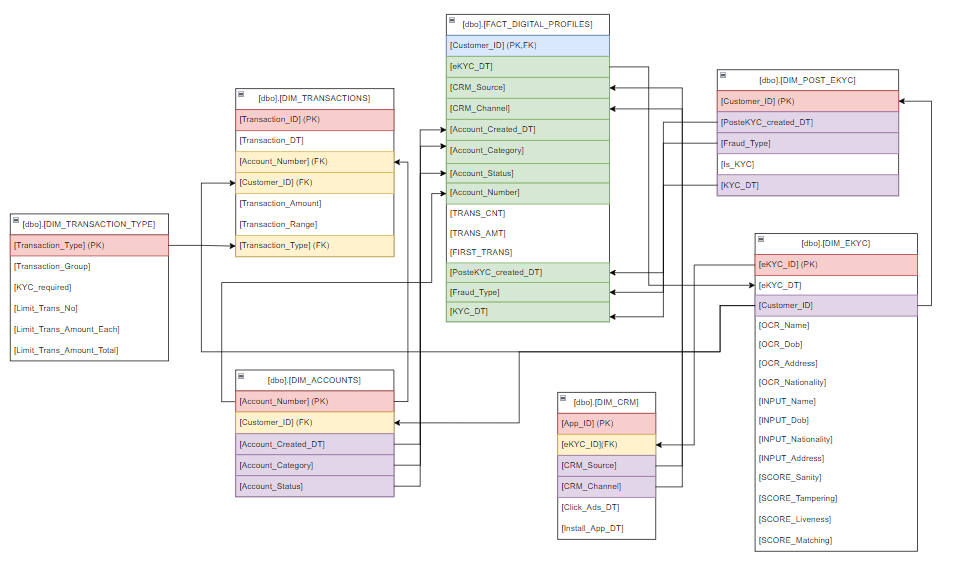

# **DATA PREPARATION**

**Feature Selection**

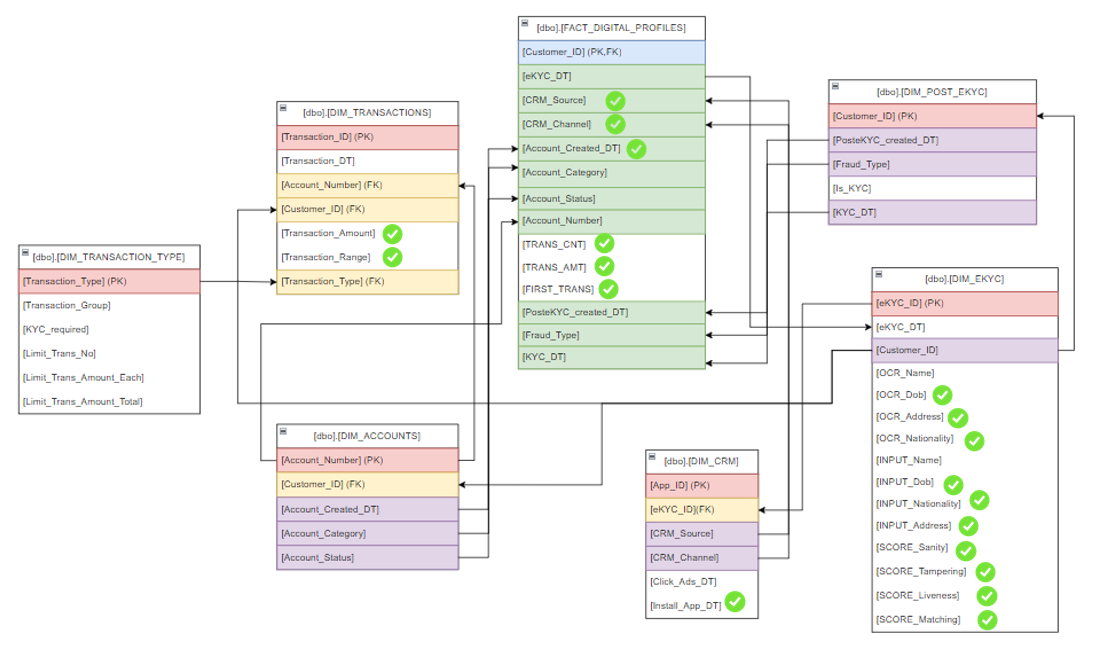

**Modelling Data Preparation**

## **Feature Engineering**

In [ ]:
!pip install pyodbc
!pip install sqlserverport
!sudo apt-get install unixodbc-dev
!pip install pyodbc
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.5/343.5 kB 5.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unixodbc-dev is already the newest version (2.3.9-5).
unixodbc-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add /etc/apt/trusted.gpg
curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo apt install --fix-broken
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
import pyodbc
import pandas as pd
import sqlserverport
import urllib
import sqlalchemy as sa

### **Loading Dataset**

#### With pyodbc

In [ ]:
import pyodbc
import pandas as pd

In [ ]:
SERVER = 'DESKTOP-H49K40G\MSSQLSERVER1'
DATABASE = 'DWH'

In [ ]:
connectionString ='Driver={ODBC Driver 17 for SQL Server};'+f'Server={SERVER};'+ f'Database={DATABASE};'+'Trusted_Connection=yes;'

In [ ]:
connectionString

'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-H49K40G\\MSSQLSERVER1;Database=DWH;Trusted_Connection=yes;'

In [ ]:
conn = pyodbc.connect(connectionString)

#### With sqlalchemy as sa

In [ ]:
# Engine
engine = sa.create_engine(f'mssql+pyodbc://{SERVER}/{DATABASE}?driver=SQL Server?Trusted_Connection=yes')

In [ ]:
# establishing the connection to the databse using engine as an interface
conn = engine.connect()
# printing names of the tables present in the database
print(engine.table_names())

#### Get Dataframe

In [ ]:
query_scripts = """
WITH N AS
(
	SELECT F.[CRM_Channel]
		  ,F.[Customer_ID]
		  ,C.[Install_App_DT]
		  ,F.[eKYC_DT]
		  ,[Account_Created_DT]
		  ,[FIRST_TRANS]
		  ,[TRANS_CNT]
		  ,T.[Transaction_Range] [First_Transaction_Range]
		  ,E.[OCR_Nationality]
		  ,DATEDIFF(YEAR, E.[OCR_Dob], SYSDATETIME()) [AGE]
		  ,E.[SCORE_Liveness]
		  ,E.[SCORE_Matching]
		  ,E.[SCORE_Sanity]
		  ,E.[SCORE_Tampering]
		  ,[FRAUD_TYPE]
	  FROM [DWH].[dbo].[FACT_DIGITAL_PROFILES] F
	  LEFT JOIN [DWH].[dbo].[DIM_CRM] C ON C.[App_ID] =  F.[App_ID]
	  LEFT JOIN  [DWH].[dbo].[DIM_EKYC] E ON E.[eKYC_ID] = C.[eKYC_ID]
	  LEFT JOIN  (SELECT [Customer_ID], [Transaction_Range]
						, ROW_NUMBER() OVER (PARTITION BY [Customer_ID] ORDER BY [Transaction_DT]) ROW_
				   FROM [DWH].[dbo].[DIM_TRANSACTIONS]) T ON ROW_ = 1 AND T.[Customer_ID] = F.[Customer_ID]
	  LEFT JOIN [BusinessCase].[dbo].[Region] R ON R.[Province_Name] = E.[OCR_Address]
 )

SELECT  [Customer_ID], [CRM_Channel]
		, DATEDIFF(DAY,[Install_App_DT], [eKYC_DT]) DT_TO_EKYC
		, DATEDIFF(DAY,[eKYC_DT], [Account_Created_DT]) DT_TO_CREATE_ACC
		, DATEDIFF(DAY,[Account_Created_DT], [FIRST_TRANS]) DT_TO_FT
		, [TRANS_CNT]
		, [First_Transaction_Range]
		, IIF([OCR_Nationality]<>'VIETNAMESE','FOREIGNER',[OCR_Nationality]) [Nationality]
		, IIF(AGE < 22, '21-', IIF(AGE<26, '22-25', IIF(AGE<30, '26-29', IIF(AGE<34, '30-33','34+')))) AGE_GROUP_range
		, [SCORE_Liveness]
		, [SCORE_Matching]
		, [SCORE_Sanity]
		, [SCORE_Tampering]
		, IIF([FRAUD_TYPE]<>'CHECKED' OR  [FRAUD_TYPE] IS NULL, 'NORMAL', 'FRAUD') [LABEL]
FROM N;
"""

In [ ]:
SQL_Query = pd.read_sql_query(query_scripts, conn)
data = pd.DataFrame(SQL_Query)

In [ ]:
# Backup
df_org = pd.read_csv('/content/drive/MyDrive/Session Slides/Bigcourse/Case 4/DataPreparationOutput.csv')

In [ ]:
df = df_org.iloc[:,1:]

In [ ]:
df.head(5)

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,Telesale,0,0,3,1,4 - HIGH,VIETNAMESE,21-,0.92,0.99,0.87,0.99,NORMAL
1,Partnership,16,6,18,1,4 - HIGH,VIETNAMESE,21-,0.97,0.96,0.95,0.88,NORMAL
2,Telesale,43,0,83,2,2 - MEDIUM LOW,VIETNAMESE,21-,0.86,0.90,0.87,0.92,NORMAL
3,Telesale,41,7,10,1,3 - MEDIUM HIGH,VIETNAMESE,21-,0.96,0.96,0.99,0.90,NORMAL
4,Partnership,143,22,45,1,4 - HIGH,VIETNAMESE,26-29,0.89,0.89,0.92,0.97,NORMAL


In [ ]:
# Columns
columns = df.columns
columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Nationality',
       'AGE_GROUP_range', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity',
       'SCORE_Tampering', 'LABEL'],
      dtype='object')

In [ ]:
# Target column
target_column = ['LABEL']
# Train columns
train_columns = columns.difference(target_column)
# Num vs Cat
num_columns = ['DT_TO_EKYC','DT_TO_CREATE_ACC', 'DT_TO_FT','TRANS_CNT', 'SCORE_Liveness', 'SCORE_Matching','SCORE_Sanity','SCORE_Tampering']
cat_columns = (columns.difference(num_columns))

In [ ]:
print('Numerics:', num_columns)
print('Categorical:', cat_columns)


Numerics: ['DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT', 'TRANS_CNT', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering']
Categorical: Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range', 'LABEL',
       'Nationality'],
      dtype='object')


In [ ]:
for i in cat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
26-29    0.25
30-33    0.24
22-25    0.24
21-      0.22
34+      0.05
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: CRM_Channel -----------
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: CRM_Channel, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0 - NO TRANS       0.74
4 - HIGH           0.19
3 - MEDIUM HIGH    0.06
2 - MEDIUM LOW     0.01
1 - LOW            0.00
Name: First_Transaction_Range, dtype: float64
--------- Value report on column: LABEL -----------
NORMAL    0.92
FRAUD     0.08
Name: LABEL, dtype: float64
--------- Value report on column: Nationality -----------
VIETNAMESE    0.98
FOREIGNER     0.02
Name: Nationality, dtype: float64


### Categorical encoder

In [ ]:
# df.replace({'CURRENT_OUTCOME':{'yes':1,'no':0}})

#### Binary columns

In [ ]:
# Binary columns
bin_columns = ['Nationality','LABEL']
df[bin_columns].head(5)

,Nationality,LABEL
0,VIETNAMESE,NORMAL
1,VIETNAMESE,NORMAL
2,VIETNAMESE,NORMAL
3,VIETNAMESE,NORMAL
4,VIETNAMESE,NORMAL


In [ ]:
replace_dict = {'Nationality': {'FOREIGNER':1,'VIETNAMESE':0}
                ,'LABEL': {'FRAUD':1,'NORMAL':0}}

In [ ]:
for i in bin_columns:
  df = df.replace(replace_dict[i])

In [ ]:
df = df.rename(columns={"Nationality": "Is_foreign", "LABEL": "Is_fraud"})

In [ ]:
df.head(5)

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Is_foreign,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,Is_fraud
0,Telesale,0,0,3,1,4 - HIGH,0,21-,0.92,0.99,0.87,0.99,0
1,Partnership,16,6,18,1,4 - HIGH,0,21-,0.97,0.96,0.95,0.88,0
2,Telesale,43,0,83,2,2 - MEDIUM LOW,0,21-,0.86,0.90,0.87,0.92,0
3,Telesale,41,7,10,1,3 - MEDIUM HIGH,0,21-,0.96,0.96,0.99,0.90,0
4,Partnership,143,22,45,1,4 - HIGH,0,26-29,0.89,0.89,0.92,0.97,0


#### Other categorical columns

In [ ]:
# Other cat_columns
ocat_columns = cat_columns.difference(bin_columns)
df[ocat_columns].head(5)


,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,21-,Telesale,4 - HIGH
1,21-,Partnership,4 - HIGH
2,21-,Telesale,2 - MEDIUM LOW
3,21-,Telesale,3 - MEDIUM HIGH
4,26-29,Partnership,4 - HIGH


In [ ]:
ocat_columns

Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range'], dtype='object')

In [ ]:
for i in ocat_columns:
  if i != 'CRM_Channel':
    df[i] = df[i].astype('category').cat.codes

In [ ]:
df[ocat_columns].head(5)

,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,0,Telesale,4
1,0,Partnership,4
2,0,Telesale,2
3,0,Telesale,3
4,2,Partnership,4


In [ ]:
for i in ocat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
2    0.25
3    0.24
1    0.24
0    0.22
4    0.05
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: CRM_Channel -----------
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: CRM_Channel, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0    0.74
4    0.19
3    0.06
2    0.01
1    0.00
Name: First_Transaction_Range, dtype: float64


=> Rule:


1.   AGE_GROUP_range:
*   21- - 0
*   22-25 - 1
*   26-29  - 2
*   30-34 - 3
*   34+ - 4

2.   First_Transaction_Range
*   No Trans - 0
*   LOW - 1
*   MEDIUM LOW - 2
*   MEDIUM HIGH - 3
*   HIGH - 4

#### **One-hot encoding**

3.   CRM_Channel
*   Digital Direct Sale
*   Ecosystem
*   Partnership
*   RB
*   Telesale

In [ ]:
one_hot = pd.get_dummies(df['CRM_Channel'])

In [ ]:
one_hot

,Digital Direct Sale,Ecosystem,Partnership,RB,Telesale
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,1,0,0
...,...,...,...,...,...
47111,1,0,0,0,0
47112,0,1,0,0,0
47113,0,0,1,0,0
47114,0,0,1,0,0


In [ ]:
df_list = [df, one_hot]
df_con = pd.concat(df_list, axis=1)

In [ ]:
df_con.columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Is_foreign', 'AGE_GROUP_range',
       'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering',
       'Is_fraud', 'Digital Direct Sale', 'Ecosystem', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [ ]:
df_con[num_columns].head(5)

,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering
0,0,0,3,1,0.92,0.99,0.87,0.99
1,16,6,18,1,0.97,0.96,0.95,0.88
2,43,0,83,2,0.86,0.90,0.87,0.92
3,41,7,10,1,0.96,0.96,0.99,0.90
4,143,22,45,1,0.89,0.89,0.92,0.97


### Distribution on Target

In [ ]:
columns = df_con.columns
# Target column
target_column = ['Is_fraud']
# Train columns
train_columns = columns.difference(target_column+['CRM_Channel'])

In [ ]:
X = df_con[train_columns]
y = df_con[target_column]

In [ ]:
# Data size
df_con.shape[0]

47116

<Axes: ylabel='target_column'>

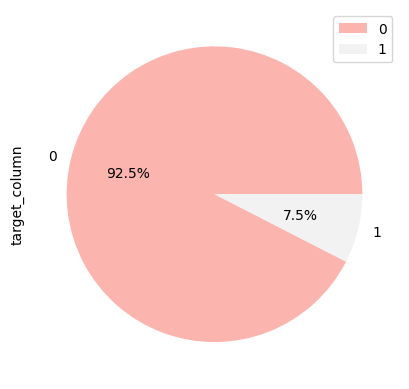

In [ ]:
y.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1') #https://matplotlib.org/stable/tutorials/colors/colormaps.html#

The value of current outcome is imbalance and as we have only 47,116 records -> not much for downsampling -> we upweighting instead

In [ ]:
X.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,0,0,0,3,0,0,4,0,0,0,0.92,0.99,0.87,0.99,1,1
1,0,6,16,18,0,0,4,0,1,0,0.97,0.96,0.95,0.88,1,0
2,0,0,43,83,0,0,2,0,0,0,0.86,0.90,0.87,0.92,2,1
3,0,7,41,10,0,0,3,0,0,0,0.96,0.96,0.99,0.90,1,1
4,2,22,143,45,0,0,4,0,1,0,0.89,0.89,0.92,0.97,1,0


In [ ]:
y.head(5)

,Is_fraud
0,0
1,0
2,0
3,0
4,0


#### **Upsampling with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

su = SMOTE(random_state=42)
X_su, y_su = su.fit_resample(X, y)

<Axes: ylabel='target_column'>

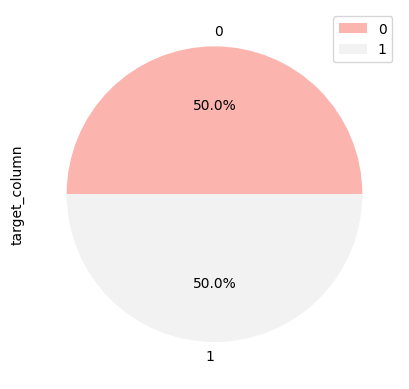

In [ ]:
y_su.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1') #https://matplotlib.org/stable/tutorials/colors/colormaps.html#

### Outlier Handler

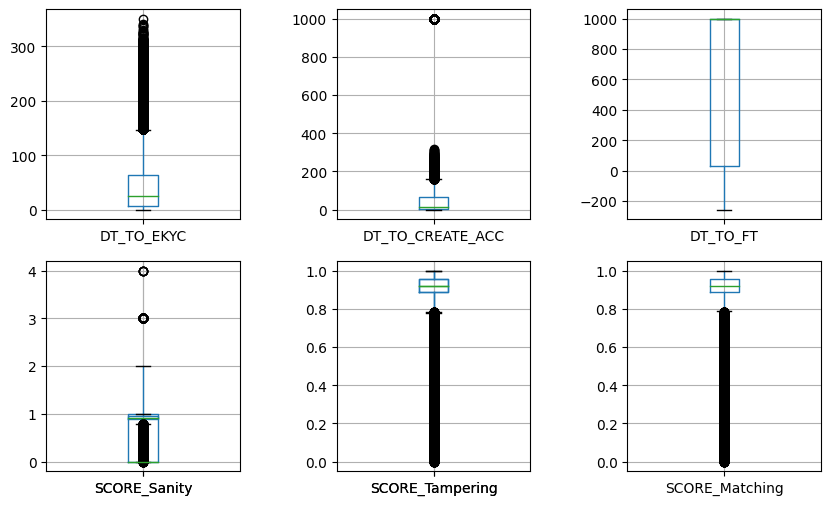

In [ ]:
import matplotlib.pyplot as plt

# df[num_columns].plot(
#     kind='box',
#     subplots=True,
#     sharey=False,
#     figsize=(10, 6)
# )

# 4 subplots in one row
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(len(num_columns)):
    if i > 2:
      j=1
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i%3])
    else:
      j=0
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i])

# draw boxplots - for one column in each subplot
# data_df.boxplot('age', ax=ax[0])
# data_df.boxplot('station_distance', ax=ax[1])
# data_df.boxplot('stores_count', ax=ax[2])
# data_df.boxplot('unit_price', ax=ax[3])

plt.subplots_adjust(wspace=0.5)

plt.show()

In [ ]:
X_su.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,0,0,0,3,0,0,4,0,0,0,0.92,0.99,0.87,0.99,1,1
1,0,6,16,18,0,0,4,0,1,0,0.97,0.96,0.95,0.88,1,0
2,0,0,43,83,0,0,2,0,0,0,0.86,0.90,0.87,0.92,2,1
3,0,7,41,10,0,0,3,0,0,0,0.96,0.96,0.99,0.90,1,1
4,2,22,143,45,0,0,4,0,1,0,0.89,0.89,0.92,0.97,1,0


In [ ]:
import numpy as np

''' Detection '''
def outlier_handler(df,col):
    # IQR
    # Calculate the upper and lower limits
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
    # Create arrays of Boolean values indicating the outlier rows
    # upper_array = np.where(X_su[col]>=upper)[0]
    # lower_array = np.where(X_su[col]<=lower)[0]

    # Removing the outliers
    # X_su.drop(index=upper_array, inplace=True)
    # X_su.drop(index=lower_array, inplace=True)




In [ ]:
for i in num_columns:
    X_su = outlier_handler(X_su,i)

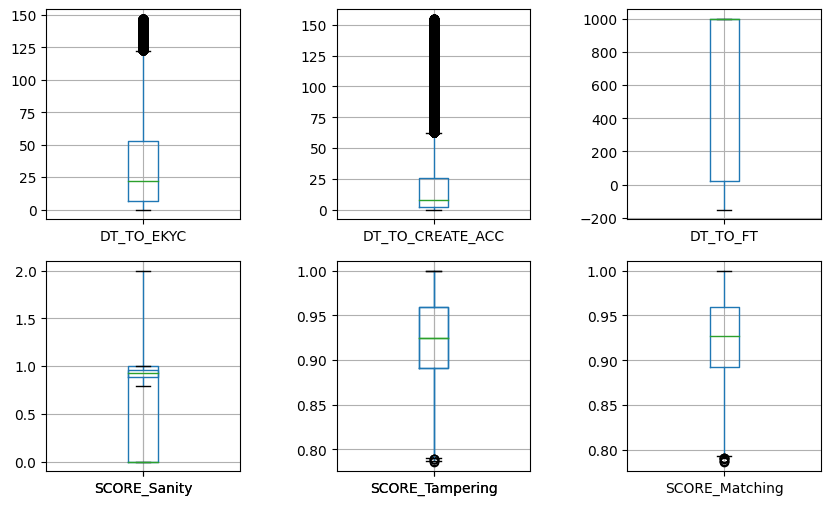

In [ ]:
import matplotlib.pyplot as plt

# df[num_columns].plot(
#     kind='box',
#     subplots=True,
#     sharey=False,
#     figsize=(10, 6)
# )

# 4 subplots in one row
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(len(num_columns)):
    if i > 2:
      j=1
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i%3])
    else:
      j=0
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i])

# draw boxplots - for one column in each subplot
# data_df.boxplot('age', ax=ax[0])
# data_df.boxplot('station_distance', ax=ax[1])
# data_df.boxplot('stores_count', ax=ax[2])
# data_df.boxplot('unit_price', ax=ax[3])

plt.subplots_adjust(wspace=0.5)

plt.show()

In [ ]:
# Print the new shape of the DataFrame
print("New Shape: ", X_su.shape)

New Shape:  (62943, 16)


In [ ]:
X_su.shape

(62943, 16)

In [ ]:
y_su.shape

(87126, 1)

In [ ]:
X_su.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     9,    10,
               11,
            ...
            87115, 87116, 87117, 87118, 87119, 87120, 87121, 87123, 87124,
            87125],
           dtype='int64', length=62943)

In [ ]:
# Restruct target
new_df = X_su.copy()
new_df['target'] = y_su.loc[X_su.index]

In [ ]:
new_cat_columns = X_su.columns.difference(num_columns)

In [ ]:
new_cat_columns

Index(['AGE_GROUP_range', 'Digital Direct Sale', 'Ecosystem',
       'First_Transaction_Range', 'Is_foreign', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [ ]:
for i in new_cat_columns:
  if i != 'CURRENT_OUTCOME':
    print('--------- Value report on column:',i,'-----------')
    report = X_su[i].value_counts(normalize=True,ascending=False).round(2)
    print(report)

--------- Value report on column: AGE_GROUP_range -----------
1    0.27
2    0.26
0    0.24
3    0.19
4    0.02
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: Digital Direct Sale -----------
0    0.87
1    0.13
Name: Digital Direct Sale, dtype: float64
--------- Value report on column: Ecosystem -----------
0    0.87
1    0.13
Name: Ecosystem, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0    0.63
4    0.23
3    0.13
2    0.01
1    0.00
Name: First_Transaction_Range, dtype: float64
--------- Value report on column: Is_foreign -----------
0    0.99
1    0.01
Name: Is_foreign, dtype: float64
--------- Value report on column: Partnership -----------
0    0.88
1    0.12
Name: Partnership, dtype: float64
--------- Value report on column: RB -----------
0    0.87
1    0.13
Name: RB, dtype: float64
--------- Value report on column: Telesale -----------
0    0.88
1    0.12
Name: Telesale, dtype: float64


### **Data Selection**

In [ ]:
X_su.corr().round(2)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
AGE_GROUP_range,1.00,-0.02,-0.01,0.01,0.04,0.03,-0.01,0.01,0.03,0.03,-0.01,0.01,-0.01,-0.00,-0.01,0.04
DT_TO_CREATE_ACC,-0.02,1.00,0.18,-0.04,-0.03,-0.02,0.04,0.01,-0.02,-0.02,0.02,-0.01,-0.00,0.01,0.03,-0.02
DT_TO_EKYC,-0.01,0.18,1.00,-0.00,-0.03,-0.03,0.00,0.01,-0.00,-0.03,0.01,0.02,-0.01,-0.00,0.01,-0.03
DT_TO_FT,0.01,-0.04,-0.00,1.00,0.03,0.04,-0.98,-0.00,0.01,0.02,0.00,0.01,0.01,-0.00,-0.96,0.02
Digital Direct Sale,0.04,-0.03,-0.03,0.03,1.00,-0.15,-0.02,0.02,-0.14,-0.14,-0.00,-0.01,0.00,0.01,-0.02,-0.14
Ecosystem,0.03,-0.02,-0.03,0.04,-0.15,1.00,-0.03,0.02,-0.15,-0.15,0.01,-0.02,0.01,-0.02,-0.02,-0.15
First_Transaction_Range,-0.01,0.04,0.00,-0.98,-0.02,-0.03,1.00,0.00,-0.00,-0.02,-0.00,-0.01,-0.01,0.00,0.94,-0.01
Is_foreign,0.01,0.01,0.01,-0.00,0.02,0.02,0.00,1.00,0.03,0.03,0.00,0.00,-0.00,-0.00,0.01,0.02
Partnership,0.03,-0.02,-0.00,0.01,-0.14,-0.15,-0.00,0.03,1.00,-0.14,-0.01,0.00,0.00,0.00,-0.00,-0.14
RB,0.03,-0.02,-0.03,0.02,-0.14,-0.15,-0.02,0.03,-0.14,1.00,0.00,-0.02,-0.01,0.00,-0.01,-0.14


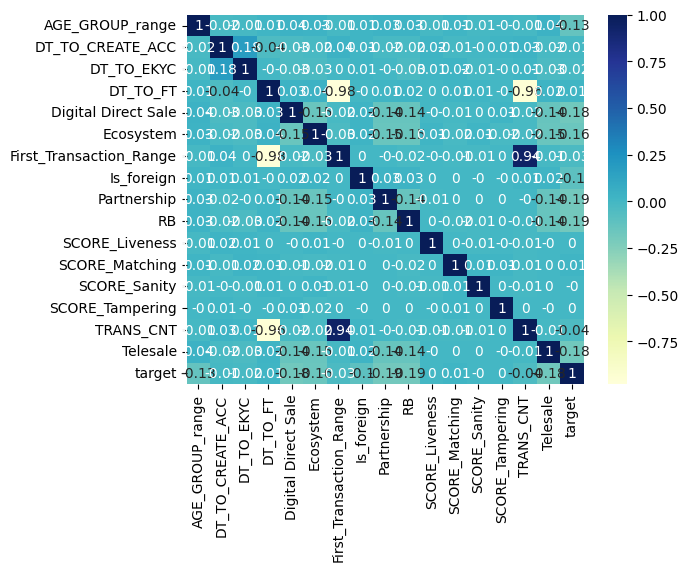

In [ ]:
# import modules
import matplotlib.pyplot as mp
import seaborn as sb


# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
corr_mat = new_df.corr().round(2)

# plotting correlation heatmap
dataplot = sb.heatmap(corr_mat, cmap="YlGnBu", annot=True)

# displaying heatmap
mp.show()

In [ ]:
abs(corr_mat['target']).quantile(0.5)

0.04

In [ ]:
#corr_mat[abs(corr_mat['target'])>0.04]

We only take the top 50% of correlation with target
-> we remove all the columns with abs correlation less than 0.04

In [ ]:
corr_mat[abs(corr_mat['target'])<=0.04]

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale,target
DT_TO_CREATE_ACC,-0.02,1.00,0.18,-0.04,-0.03,-0.02,0.04,0.01,-0.02,-0.02,0.02,-0.01,-0.00,0.01,0.03,-0.02,-0.01
DT_TO_EKYC,-0.01,0.18,1.00,-0.00,-0.03,-0.03,0.00,0.01,-0.00,-0.03,0.01,0.02,-0.01,-0.00,0.01,-0.03,-0.02
DT_TO_FT,0.01,-0.04,-0.00,1.00,0.03,0.04,-0.98,-0.00,0.01,0.02,0.00,0.01,0.01,-0.00,-0.96,0.02,0.01
First_Transaction_Range,-0.01,0.04,0.00,-0.98,-0.02,-0.03,1.00,0.00,-0.00,-0.02,-0.00,-0.01,-0.01,0.00,0.94,-0.01,-0.03
SCORE_Liveness,-0.01,0.02,0.01,0.00,-0.00,0.01,-0.00,0.00,-0.01,0.00,1.00,0.00,-0.01,-0.00,-0.01,-0.00,0.00
SCORE_Matching,0.01,-0.01,0.02,0.01,-0.01,-0.02,-0.01,0.00,0.00,-0.02,0.00,1.00,0.01,0.01,-0.01,0.00,0.01
SCORE_Sanity,-0.01,-0.00,-0.01,0.01,0.00,0.01,-0.01,-0.00,0.00,-0.01,-0.01,0.01,1.00,0.00,-0.01,0.00,-0.00
SCORE_Tampering,-0.00,0.01,-0.00,-0.00,0.01,-0.02,0.00,-0.00,0.00,0.00,-0.00,0.01,0.00,1.00,0.00,-0.00,0.00
TRANS_CNT,-0.01,0.03,0.01,-0.96,-0.02,-0.02,0.94,0.01,-0.00,-0.01,-0.01,-0.01,-0.01,0.00,1.00,-0.01,-0.04


In [ ]:
train_df = new_df.drop(columns=['DT_TO_CREATE_ACC','DT_TO_EKYC','DT_TO_FT','First_Transaction_Range','SCORE_Liveness','SCORE_Matching','SCORE_Sanity','SCORE_Tampering','TRANS_CNT'])

In [ ]:
bk_train_df = new_df.drop(columns=['DT_TO_CREATE_ACC','DT_TO_EKYC','DT_TO_FT','First_Transaction_Range','SCORE_Liveness','SCORE_Matching','SCORE_Sanity','SCORE_Tampering','TRANS_CNT'])

In [ ]:
train_df

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
87120,2,0,0,0,0,1,0,1
87121,0,0,0,0,0,1,0,1
87123,2,0,0,0,0,0,0,1
87124,2,0,0,0,0,0,0,1


<Axes: >

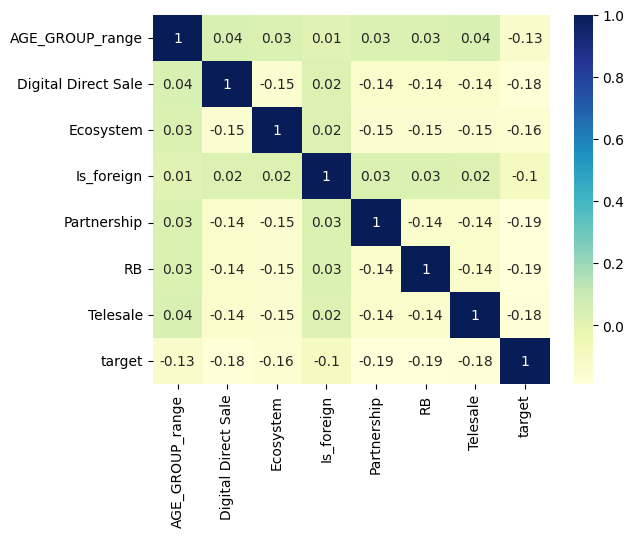

In [ ]:
sb.heatmap(round(train_df.corr(),2), cmap="YlGnBu", annot=True)

In [ ]:
bk_train_df.shape

(62943, 8)

In [ ]:
train_df.shape

(62943, 8)

## Hold-out set

In [ ]:
hold_out_df = train_df.sample(12500)

In [ ]:
hold_out_df.shape

(12500, 8)

In [ ]:
removed_df = train_df.index.isin(hold_out_df.index)

In [ ]:
train_df = train_df[~removed_df]

In [ ]:
train_df.shape

(50443, 8)

# DATA MODEL

In [ ]:
import sklearn

In [ ]:
train_df.shape

(50443, 8)

In [ ]:
train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
5,3,0,0,0,0,1,0,0
6,1,0,0,0,1,0,0,0


In [ ]:
X = train_df.iloc[:,:7]
y = train_df.iloc[:,-1]

In [ ]:
X.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
5,3,0,0,0,0,1,0
6,1,0,0,0,1,0,0


In [ ]:
y.head(5)

0    0
2    0
3    0
5    0
6    0
Name: target, dtype: int64

### Feature Scaler

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

scaled_X = scale.fit_transform(X)

print(scaled_X)

[[-1.31148087 -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
   2.67748144]
 [-1.31148087 -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
   2.67748144]
 [-1.31148087 -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
   2.67748144]
 ...
 [ 0.46068708 -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
  -0.37348531]
 [ 0.46068708 -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
  -0.37348531]
 [-0.4253969  -0.38037977 -0.39146706 ... -0.37413977 -0.38174436
  -0.37348531]]


In [ ]:
X_scaled = pd.DataFrame(scaled_X)
X_scaled.columns = X.columns

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_scaled, y, test_size=0.25, random_state=18)


In [ ]:
X_train.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
13582,2.232855,-0.38038,-0.391467,-0.102356,-0.374140,2.619554,-0.373485
2958,-0.425397,-0.38038,-0.391467,-0.102356,2.672798,-0.381744,-0.373485
41670,0.460687,-0.38038,-0.391467,-0.102356,-0.374140,-0.381744,-0.373485
10268,1.346771,-0.38038,-0.391467,-0.102356,2.672798,-0.381744,-0.373485
32284,-1.311481,-0.38038,-0.391467,-0.102356,-0.374140,-0.381744,-0.373485


In [ ]:
y.head(5)

0    0
2    0
3    0
5    0
6    0
Name: target, dtype: int64

In [ ]:
X_train.shape

(37832, 7)

In [ ]:
y_train.shape

(37832,)

## Model comprehension

In [ ]:
#Import all the learning algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Import some utilities of sklearn to compare algorithms
from sklearn import  model_selection
from sklearn.metrics import classification_report #Reporting metric
from sklearn.metrics import confusion_matrix #Confusion_matrix Reporting
from sklearn.metrics import accuracy_score #Accuracy calculating

In [ ]:
# Prepare the configuration to run the test
results=[]
names=[]

In [ ]:
# Prepare an array with all the algorithms
models = []
models.append(('LR',LogisticRegression()))
models.append(('CARD',DecisionTreeClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('NB',GaussianNB()))
models.append(('RFC',RandomForestClassifier()))

In [ ]:
#Evaluate each model in turn
for name,model in models:
    kfold=model_selection.KFold(n_splits=10)
    cv_results=model_selection.cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg="%s:%f(%f)"%(name,cv_results.mean(),cv_results.std())
    print(msg)

LR:0.612812(0.012087)
CARD:0.612812(0.012087)
KNN:0.708269(0.020321)
LDA:0.612812(0.012087)
NB:0.764859(0.019622)
RFC:0.612812(0.012087)


## Model Evaluation

### **Boxplot algorithm comparison**

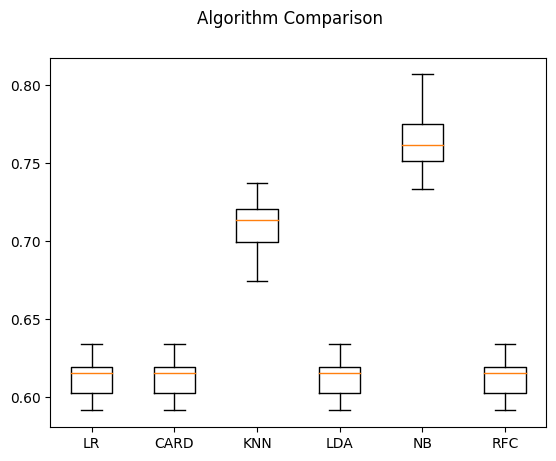

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

=> NB: Good Recall

### **ROC CURVE FOR COMPARISON**

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_scaled,y)
y_score_lr = cross_val_predict(lr, X_scaled, y, method='decision_function',cv=10)
fpr, tpr, threshold = roc_curve(y,y_score_lr)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
card = DecisionTreeClassifier()
card.fit(X_scaled,y)
y_score_card = cross_val_predict(card, X_scaled, y, method='predict_proba',cv=10)
fpr_card, tpr_card, threshold_card = roc_curve(y, y_score_card[:, 1])

# K Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_scaled,y)
knc_results = cross_val_score(knc,X_scaled,y,scoring='accuracy')
y_score_knn = cross_val_predict(knc,X_scaled,y,method='predict_proba',cv=10)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y,y_score_knn[:,1])

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled,y)
lda_results = cross_val_score(lda,X_scaled,y,scoring='accuracy')
y_score_lda = cross_val_predict(lda,X_scaled,y,method='predict_proba',cv=10)
fpr_lda, tpr_lda, threshold_lda = roc_curve(y,y_score_lda[:,1])

# GaussianNB
from sklearn.naive_bayes import GaussianNB

gnbc = GaussianNB()
gnbc.fit(X_scaled,y)
gnbc_results = cross_val_score(gnbc,X_scaled,y,scoring='accuracy')
y_score_gnb = cross_val_predict(gnbc,X_scaled,y,method='predict_proba',cv=10)
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y,y_score_gnb[:,1])

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_scaled,y)
rfc_results = cross_val_score(rfc,X_scaled,y,scoring='accuracy')
y_score_rfc = cross_val_predict(rfc,X_scaled,y,method='predict_proba',cv=10)
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y,y_score_rfc[:,1])



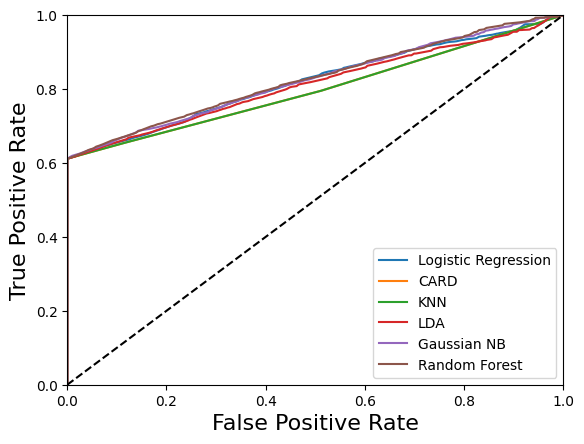

<Figure size 1000x600 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
# ROC Curve for the models above
plt.plot(fpr,tpr,label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn,label='CARD')
plt.plot(fpr_knn, tpr_knn,label='KNN')
plt.plot(fpr_lda, tpr_lda,label='LDA')
plt.plot(fpr_gnb, tpr_gnb,label='Gaussian NB')
plt.plot(fpr_rfc, tpr_rfc,label='Random Forest')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(10, 6))
plt.show()
plt.show

=> RF: Good Precision

**Voting Ensemble Method**

We use soft voting ensemble method to predict the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

We fit the model to the third dataset, smallest and representative

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
Vote_Ensemble = VotingClassifier(estimators=[('nb', gnbc), ('rf', rfc)], voting='soft')

In [ ]:
Vote_Ensemble.fit(X_scaled,y)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [ ]:
Vote_Ensemble

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [ ]:
# Save model
import pickle
# save the model to disk
filename = '/content/drive/MyDrive/Session Slides/Bigcourse/Case 4/Model/finalized_model.pkl'
pickle.dump(Vote_Ensemble, open(filename, 'wb'))

# DATA EVALUATION & THRESHOLD JUSTIFICATION


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

**Loading hold out set**

In [ ]:
hold_out_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
63769,1,0,0,0,1,0,0,1
67832,2,0,0,0,0,0,0,1
36524,2,0,0,0,1,0,0,0
62271,0,0,0,0,0,0,0,1
28272,2,0,0,0,1,0,0,0


In [ ]:
X_holdout = hold_out_df.iloc[:,0:7]
y_holdout = hold_out_df.iloc[:,-1]

In [ ]:
scaled_X_test = scale.fit_transform(X_holdout)

In [ ]:
X_test_scaled = pd.DataFrame(scaled_X_test)
X_test_scaled.columns = X_scaled.columns

In [ ]:
X_test_scaled.head(5)


,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,-0.423014,-0.380793,-0.392006,-0.112052,2.641406,-0.375125,-0.374431
1,0.466119,-0.380793,-0.392006,-0.112052,-0.378586,-0.375125,-0.374431
2,0.466119,-0.380793,-0.392006,-0.112052,2.641406,-0.375125,-0.374431
3,-1.312146,-0.380793,-0.392006,-0.112052,-0.378586,-0.375125,-0.374431
4,0.466119,-0.380793,-0.392006,-0.112052,2.641406,-0.375125,-0.374431


In [ ]:
loaded_model.fit(X_test_scaled,y_holdout)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [ ]:
loaded_model.predict(X_test_scaled)

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
X_test_scaled.shape

(12500, 7)

In [ ]:
y_holdout.shape

(12500,)

### Confusion Matrix

In [ ]:
# Make predictions on the test set
y_pred = loaded_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_holdout, y_pred)
classification_report_str = classification_report(y_holdout, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      5010
           1       0.86      0.71      0.78      7490

    accuracy                           0.76     12500
   macro avg       0.76      0.77      0.76     12500
weighted avg       0.78      0.76      0.76     12500



### Justify the threshold

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_score is the result of predict_proba
# y_score should be a 2D array with shape (n_samples, n_classes)
# Let's assume we want to create a box plot for class 1
class_index = [1]
y_score = loaded_model.predict_proba(X_test_scaled)

In [ ]:
loaded_model.predict_proba(X_test_scaled)

array([[0.62159251, 0.37840749],
       [0.01042814, 0.98957186],
       [0.66512876, 0.33487124],
       ...,
       [0.01042814, 0.98957186],
       [0.63826403, 0.36173597],
       [0.0081569 , 0.9918431 ]])

In [ ]:
test = X_test_scaled.copy()
test['prob'] = loaded_model.predict_proba(X_test_scaled)[:,1]
test['output'] = loaded_model.predict(X_test_scaled)

In [ ]:
fail = test.loc[test['output']==0,'prob']
success = test.loc[test['output']==1,'prob']

Text(0.5, 1.0, 'Box Plot Comparison')

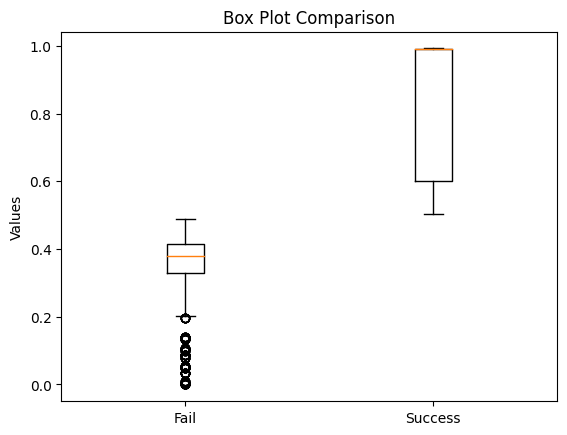

In [ ]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Create the box plots
ax.boxplot([fail, success])

# Set labels and title
ax.set_xticklabels(['Fail', 'Success'])
ax.set_ylabel('Values')
ax.set_title('Box Plot Comparison')

In [ ]:
success.describe()

count    6231.000000
mean        0.880178
std         0.185985
min         0.502999
25%         0.601873
50%         0.989572
75%         0.991843
max         0.992359
Name: prob, dtype: float64

**Try raising the threshold up to 0.45**

In [ ]:
y_pred_threshold = np.array([1 if i >= 0.45 else 0 for i in test['prob']])

In [ ]:
classification_report_str = classification_report(y_holdout, y_pred_threshold)
accuracy = accuracy_score(y_holdout, y_pred_threshold)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Threshold = 0.45
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.70      5010
           1       0.81      0.75      0.78      7490

    accuracy                           0.74     12500
   macro avg       0.73      0.74      0.74     12500
weighted avg       0.75      0.74      0.74     12500



In [ ]:
# Threshold = 0.5

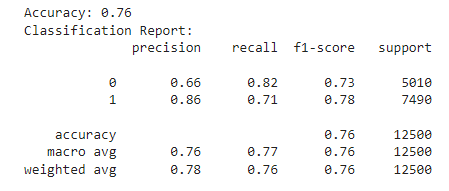

=> The accuracy drop a tiny bit (2%). However, the model become stricter in classifying a customer as normal -> lower threshold to catch fraud -> the recall for 1 and precision for 0 raise =>  => More accurate in catch 'sophisticated fraud' => In return, we lose the opportunity to save cost as the precision/right level of prediction drop

In [ ]:
y_pred_threshold_1 = np.array([1 if i >= 0.4 else 0 for i in test['prob']])

In [ ]:
accuracy_1 = accuracy_score(y_holdout, y_pred_threshold_1)
print(f"Accuracy: {accuracy_1:.2f}")
print("Classification Report:")
c1 = classification_report(y_holdout, y_pred_threshold_1)
print(c1)



Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      5010
           1       0.75      0.80      0.78      7490

    accuracy                           0.72     12500
   macro avg       0.71      0.70      0.70     12500
weighted avg       0.72      0.72      0.72     12500



### Optimize threshold

=> Remember to optimize the f1-score if you want to balance precision and recall. Also, know what you prioritize in precision or recall to make the trade-offs

In [ ]:
y_score.shape

(12500, 2)

In [ ]:
y_score_positive = y_score[:, 1]

In [ ]:
y_score_positive.shape

(12500,)

In [ ]:
print("y_test shape:", y_test.shape)
print("y_score_positive shape:", y_score_positive.shape)

y_test shape: (12611,)
y_score_positive shape: (12500,)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


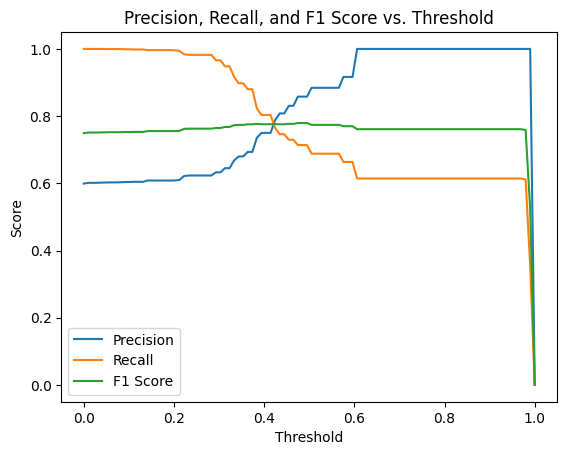

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test contains the true labels and y_score_positive contains the predicted probabilities for the positive class

# Define a range of thresholds
thresholds = np.linspace(0, 1, num=100)

# Calculate precision, recall, and F1 score for each threshold
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_score_positive >= threshold).astype(int)
    precisions.append(precision_score(y_holdout, y_pred))
    recalls.append(recall_score(y_holdout, y_pred))
    f1_scores.append(f1_score(y_holdout, y_pred))

# Plot precision, recall, and F1 score against thresholds
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

# Set labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()

# Show the plot
plt.show()

# MODEL OUTPUT

In [ ]:
bk_train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,2,0,0,0,1,0,0,0


In [ ]:
X_bk = bk_train_df.iloc[:,0:7]
y_bk = bk_train_df.iloc[:,-1]

In [ ]:
scaled_X_bk = scale.fit_transform(X_bk)

In [ ]:
loaded_model.fit(scaled_X_bk,y_bk)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [ ]:
X_bk_scaled = pd.DataFrame(scaled_X_bk)
X_bk_scaled.columns = X_scaled.columns

In [ ]:
X_bk_scaled.head(5)


,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135
1,-1.311610,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673
2,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135
3,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135
4,0.461762,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673


In [ ]:
loaded_model.predict(X_bk_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
df_fin = X_bk_scaled.copy()

In [ ]:
df_fin['y_actual'] = y_bk
df_fin['prob'] = loaded_model.predict_proba(X_bk_scaled)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
df_fin.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
1,-1.311610,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673,0.0,0.420499
2,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
3,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
4,0.461762,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673,0.0,0.369577


In [ ]:
y_pred_threshold_fin = np.array([1 if i >= 0.45 else 0 for i in df_fin['prob']])

In [ ]:
accuracy_fin = accuracy_score(y_bk, y_pred_threshold_fin)
print(f"Accuracy: {accuracy_fin:.2f}")
c_fin = classification_report(y_bk, y_pred_threshold_fin)
print(c_fin)

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     25059
           1       0.83      0.73      0.78     37884

    accuracy                           0.75     62943
   macro avg       0.74      0.75      0.74     62943
weighted avg       0.76      0.75      0.75     62943



In [ ]:
df_fin.to_csv('/content/drive/MyDrive/Session Slides/Bigcourse/Case 4/Model/output.csv')

In [ ]:
df_fin

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
1,-1.311610,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673,0.0,0.420499
2,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
3,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,2.676135,0.0,0.432656
4,0.461762,-0.380462,-0.391574,-0.10435,2.666489,-0.380434,-0.373673,0.0,0.369577
...,...,...,...,...,...,...,...,...,...
62938,0.461762,-0.380462,-0.391574,-0.10435,-0.375025,2.628574,-0.373673,1.0,0.400869
62939,-1.311610,-0.380462,-0.391574,-0.10435,-0.375025,2.628574,-0.373673,1.0,0.438415
62940,0.461762,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,-0.373673,NaN,0.989941
62941,0.461762,-0.380462,-0.391574,-0.10435,-0.375025,-0.380434,-0.373673,1.0,0.989941


In [ ]:
df

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Is_foreign,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,Is_fraud
0,Telesale,0,0,3,1,4,0,0,0.92,0.99,0.87,0.99,0
1,Partnership,16,6,18,1,4,0,0,0.97,0.96,0.95,0.88,0
2,Telesale,43,0,83,2,2,0,0,0.86,0.90,0.87,0.92,0
3,Telesale,41,7,10,1,3,0,0,0.96,0.96,0.99,0.90,0
4,Partnership,143,22,45,1,4,0,2,0.89,0.89,0.92,0.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,Digital Direct Sale,2,23,1000,0,0,0,2,0.98,0.99,0.93,0.85,0
47112,Ecosystem,122,8,1000,0,0,0,4,0.89,0.91,0.86,0.88,0
47113,Partnership,14,0,1000,0,0,0,3,0.91,0.89,0.92,0.94,0
47114,Partnership,6,35,1000,0,0,0,2,0.87,0.97,0.86,0.94,0


In [ ]:
#df_org